# Matflow Crystal Plasticity Modelling post-processing examples

A Jupyter notebook with crystal plasticity model post-processing examples.

First, specify the workflow you would like to post-process by changing the path string of the `workflow` variable.

In [1]:

from matflow import load_workflow

# define path to completed matflow workflow directory containing result.hdf5 file...
workflow_dir = "/mnt/iusers01/jf01/y15576gb/\
postprocessing/\
034_Ti64_TIFUN-T4_TD_910C_DeformY_1mms-1_2023-01-20-143450/"

# use load_workflow to import the result.hdf5 file into jupyter as a variable...
workflow = load_workflow(workflow_dir)


Loading matflow config from /mnt/iusers01/jf01/y15576gb/.matflow/config.yml
Loading task schemas from 1 file(s)...OK!
Loading software definitions from 1 file(s)...OK!


---
## Plotting Stress-strain of a matflow-DAMASK simulation.
The following code takes a matflow workflow's `workflow.hdf5` file and plots stress against strain.

Required arguments in `workflow.yaml`:
```yaml
  - name: simulate_volume_element_loading
    method: CP_FFT
    software: DAMASK
    output_map_options:
      operations:
        - name: add_stress_Cauchy
          args: { P: P, F: F }
        - name: add_strain
          args: { F: F, t: V, m: 0 }
          opts: { add_Mises: true }

      volume_data: # For global stress-strain
        - field_name: sigma
          transforms: [mean_along_axes: 1] # mean over VE
          out_name: sigma
        - field_name: epsilon_V^0(F)_vM
          transforms: [mean_along_axes: 1] # mean over VE 
          out_name: epsilon_V^0(F)_vM

    base:
      phases:
        phase_1:
          mechanical:
            output: [F, F_e, F_p, P, L_p]
```

In [ ]:
# function help
from matflow import plotting
plotting.plot_stress_strain?

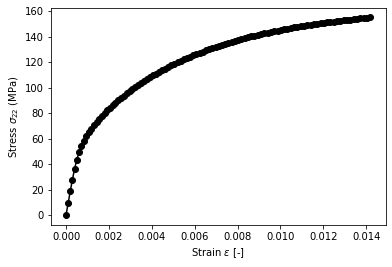

In [9]:
%matplotlib inline

from matflow import plotting
import matplotlib.pyplot as plt

# use plotting.py functions to plot data from result.hdf5
plotting.plot_stress_strain(workflow, axis="Y")

plt.gcf().savefig(workflow_dir+"Stress-Strain", dpi=300, facecolor=plt.gcf().get_facecolor(), edgecolor='none')

# Note: plots axes are labelled, but plots are not titled.
# this is so that the user may title their plot, and so that
# it may be easily combined with another plot.

---
## Plotting True-Stress Against Lattice Strain of a matflow-DAMASK Simulation
The following takes a matflow workflow's `workflow.hdf5` file and plots true stress against lattice strain for each user-defined crystallographic plane.

Import single-crystal parameters from yaml database as defdap phases

Calculate tensor component and unit vector given axis as string with matflow utils

Calculate lattice strains and plane intensities from workflow

Warning: This can take between up to 2hrs to compute for a $128^3$ volume element with 100 strain increments.

In [9]:

import matplotlib.pyplot as plt
from defdap import file_readers
from matflow import utils

# define ve_response in workflow for stress and strain data...
ve_response = workflow.tasks.simulate_volume_element_loading.elements[0].outputs.volume_element_response
true_stress = ve_response['volume_data']['sigma']['data'][:,1, 1]/1e6

# load crystal parameters
phases = file_readers.readSC_params_yaml("Ti_alpha", "Ti_beta")

axes = ["X", "Y", "Z"] # specify axis direction

latticestrain={}
plane_intensity={}
for i, axis in enumerate(axes): # plot subsequent plots for every axis direction
    tensor_comp, unit_vector = utils.tensorcomps_fromaxis(axis)

    # calculate lattice strains and count material points with that lattice strain
    latticestrain[axis], plane_intensity[axis] = lattice_strain(workflow, phases, axis=axis, tol=10)

Processing phase Ti_alpha...
Processing plane {10-10} in direction [1. 0. 0.],[0,0]...
Processing plane {0002} in direction [1. 0. 0.],[0,0]...
Processing plane {10-11} in direction [1. 0. 0.],[0,0]...
Processing plane {11-20} in direction [1. 0. 0.],[0,0]...
Processing phase Ti_beta...
Processing plane {110} in direction [1. 0. 0.],[0,0]...
Processing plane {200} in direction [1. 0. 0.],[0,0]...
Processing phase Ti_alpha...
Processing plane {10-10} in direction [0. 1. 0.],[1,1]...
Processing plane {0002} in direction [0. 1. 0.],[1,1]...
Processing plane {10-11} in direction [0. 1. 0.],[1,1]...
Processing plane {11-20} in direction [0. 1. 0.],[1,1]...
Processing phase Ti_beta...
Processing plane {110} in direction [0. 1. 0.],[1,1]...
Processing plane {200} in direction [0. 1. 0.],[1,1]...
Processing phase Ti_alpha...
Processing plane {10-10} in direction [0. 0. 1.],[2,2]...
Processing plane {0002} in direction [0. 0. 1.],[2,2]...
Processing plane {10-11} in direction [0. 0. 1.],[2,2]..

/opt/gridware2/apps/binapps/anaconda3/2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice.
/mnt/iusers01/jf01/y15576gb/.local/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


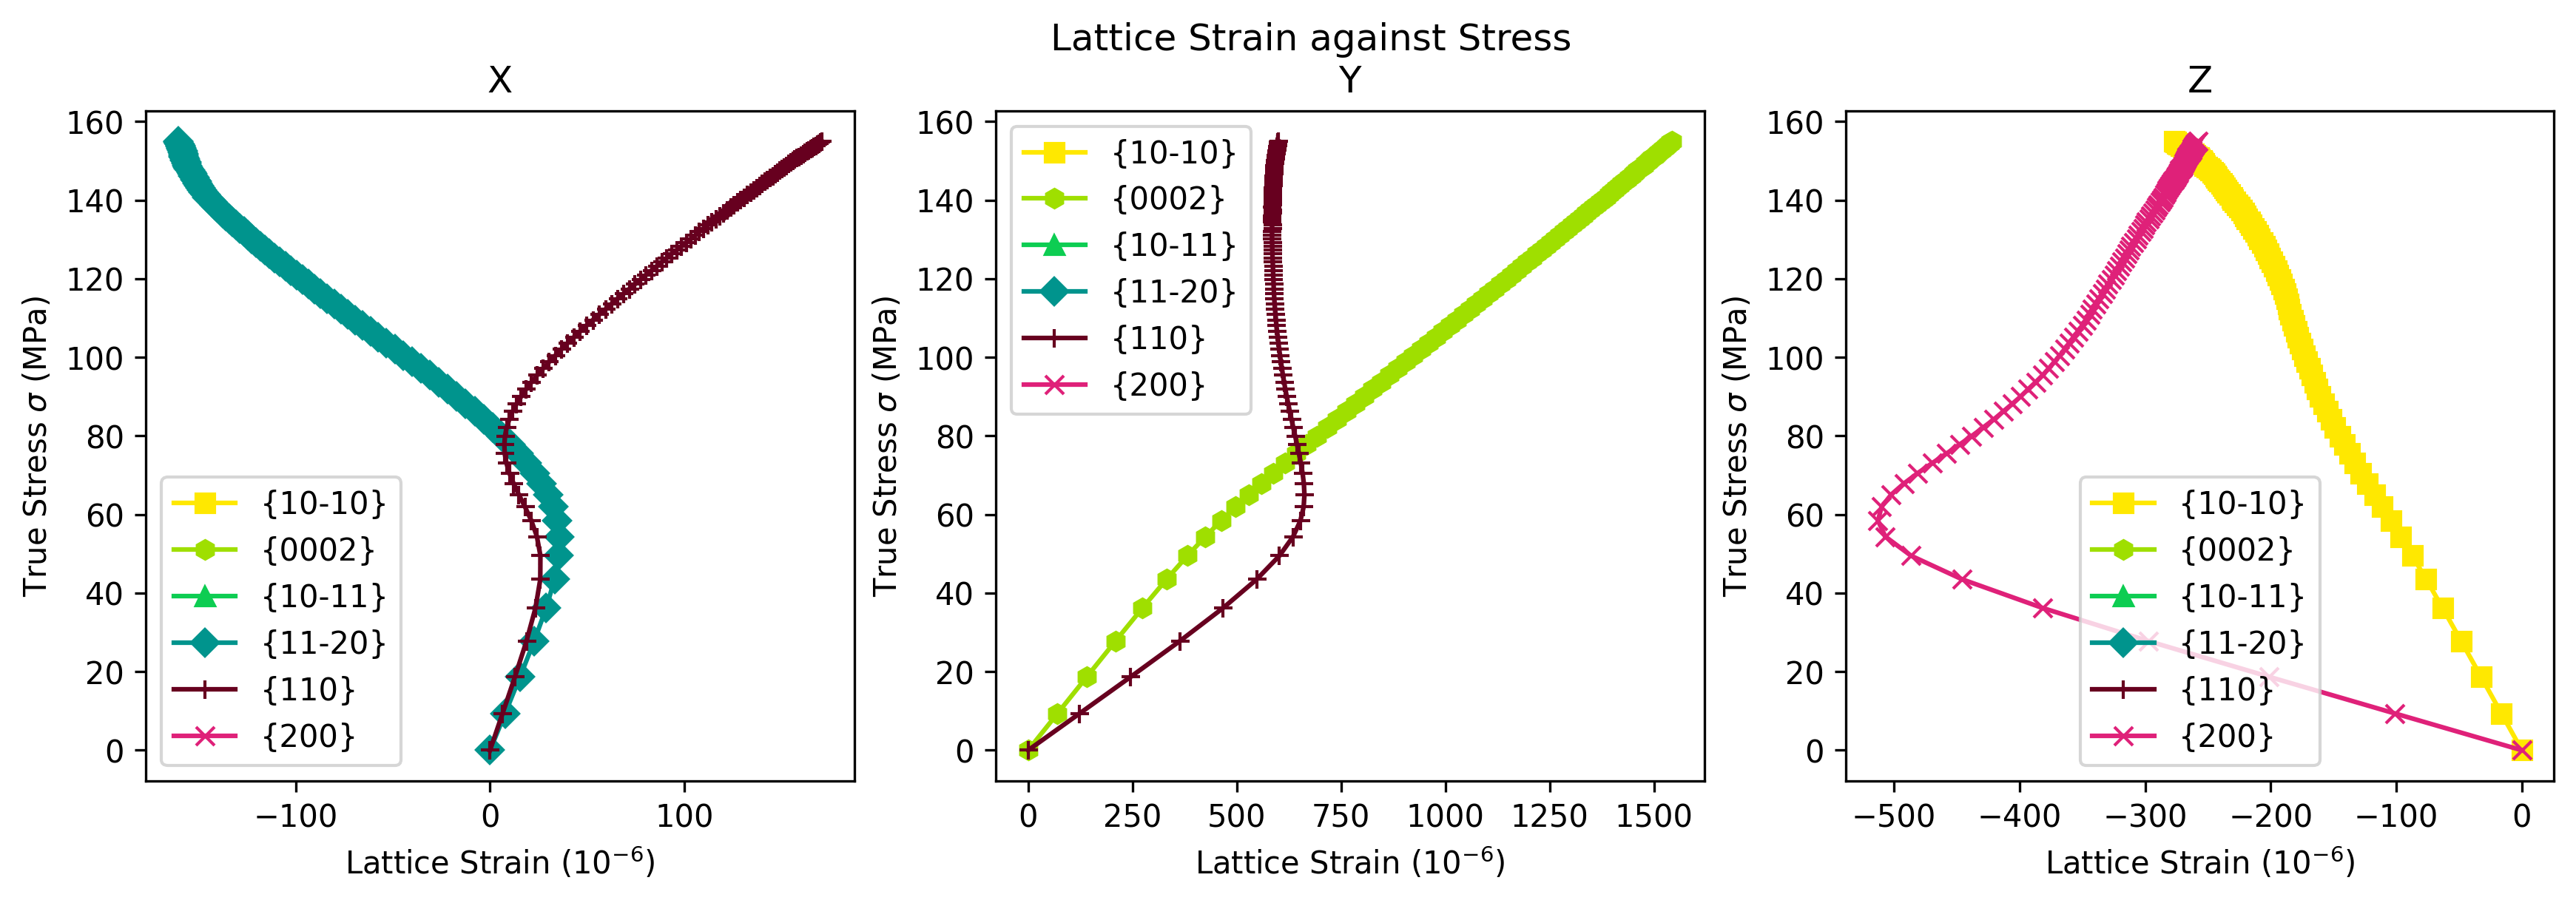

In [10]:
%matplotlib inline

fig, axs = plt.subplots(1,3, figsize=(14, 4), dpi=300) # one row, three coloumns
fig.suptitle('Lattice Strain against Stress')
for i, axis in enumerate(axes):
    plot_latticestrain(axs[i], true_stress, latticestrain, axis, incs="*", xlim=None, ylim=None)
    
plt.savefig(workflow_dir+"Latticestrain_stress", dpi='figure')


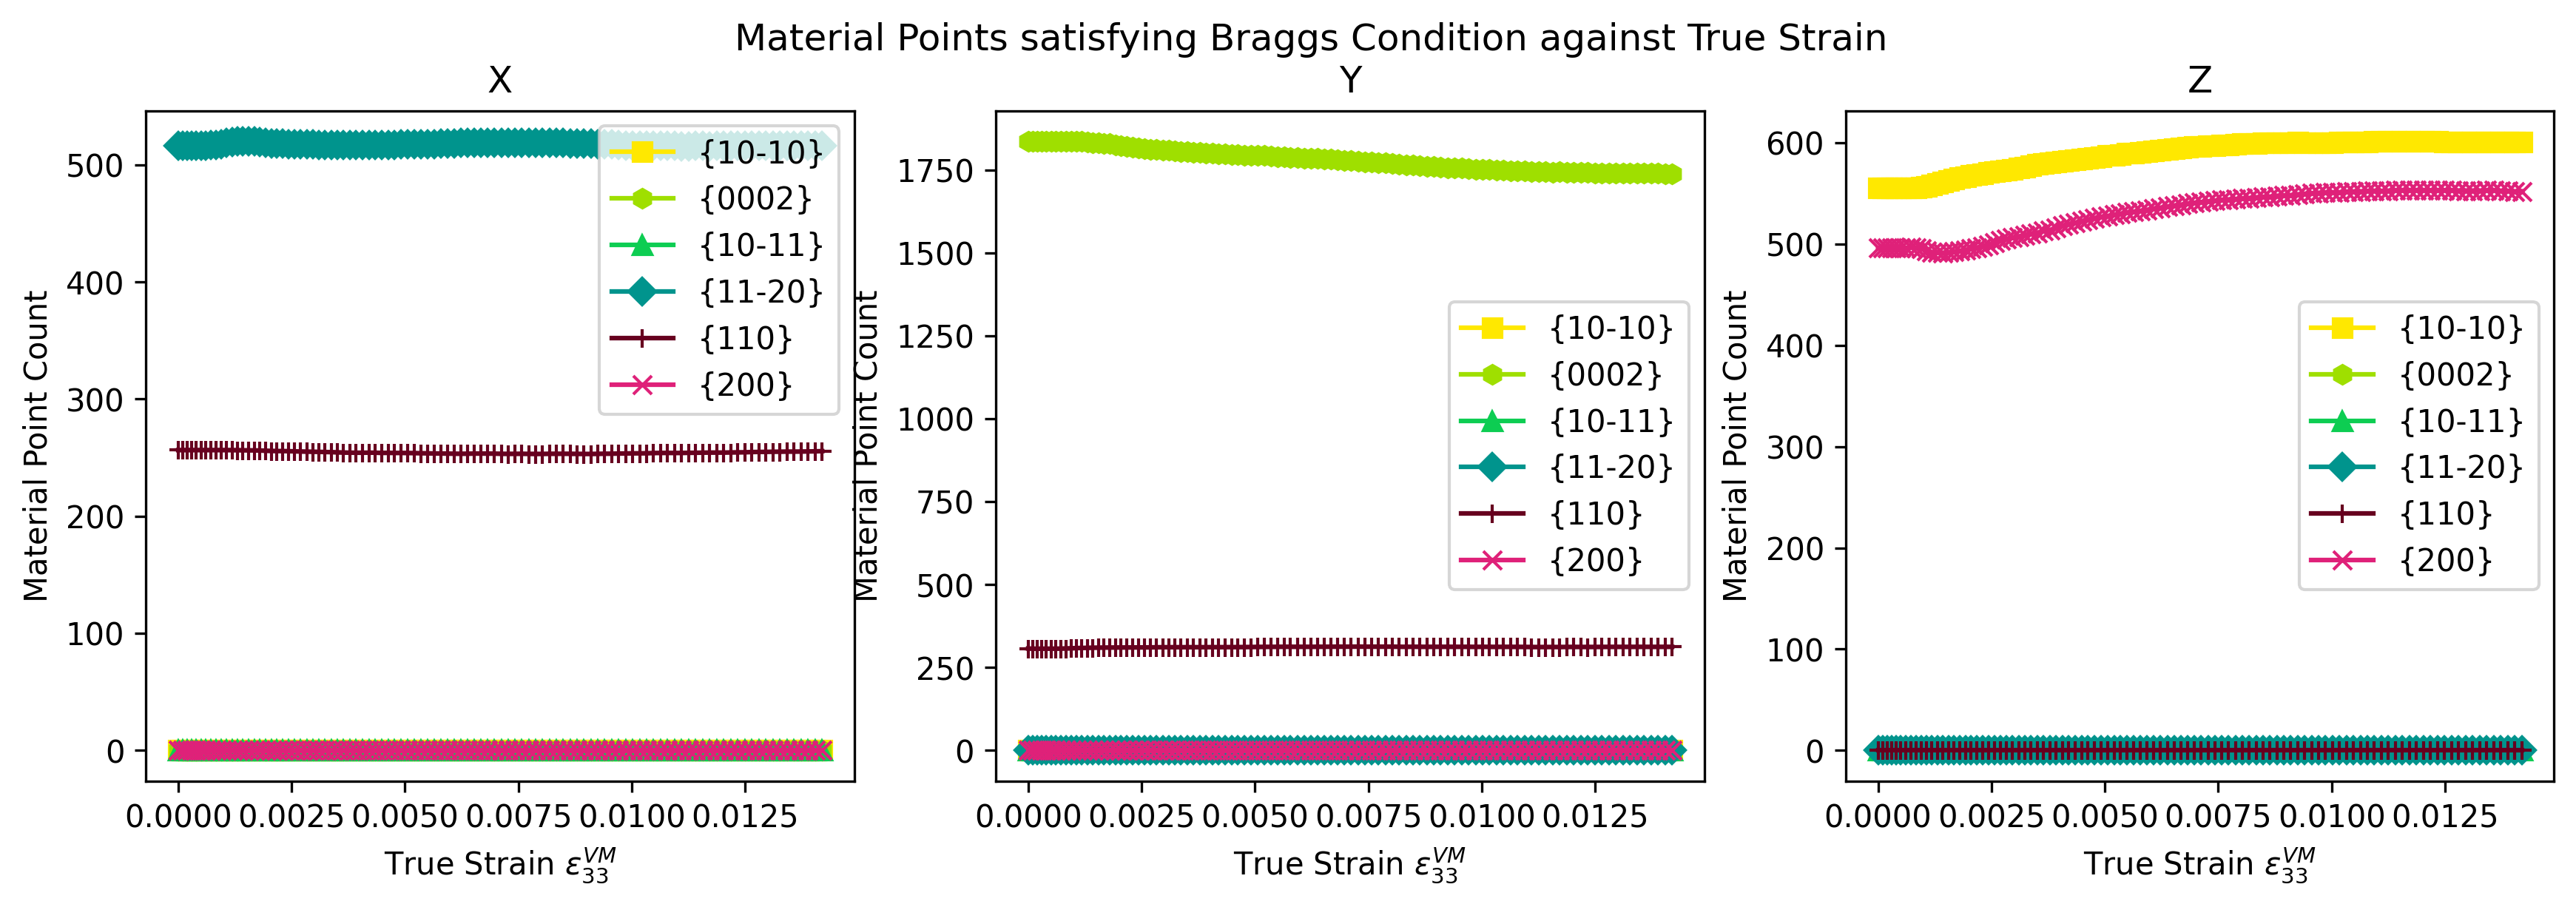

In [11]:
%matplotlib inline

ve_response = workflow.tasks.simulate_volume_element_loading.elements[0].outputs.volume_element_response
true_strain = ve_response['volume_data']['epsilon_V^0(F)_vM']['data']

fig, axs = plt.subplots(1,3, figsize=(14, 4), dpi=300) # one row, three coloumns
fig.suptitle(f"Material Points satisfying Braggs Condition against True Strain")
for i, axis in enumerate(axes):
    plot_true_strain_vs_peakint(axs[i], plane_intensity, true_strain, axis, xlim=None, ylim=None)
    
plt.savefig(workflow_dir+"Intensity_truestrain", dpi='figure')


phase: Ti_alpha Direction: X
	plane: {10-10}	lattice strain 
	plane: {0002}	lattice strain 
	plane: {10-11}	lattice strain 
	plane: {11-20}	lattice strain 
phase: Ti_alpha Direction: Y
	plane: {10-10}	lattice strain 
	plane: {0002}	lattice strain 
	plane: {10-11}	lattice strain 
	plane: {11-20}	lattice strain 
phase: Ti_alpha Direction: Z
	plane: {10-10}	lattice strain 
	plane: {0002}	lattice strain 
	plane: {10-11}	lattice strain 
	plane: {11-20}	lattice strain 


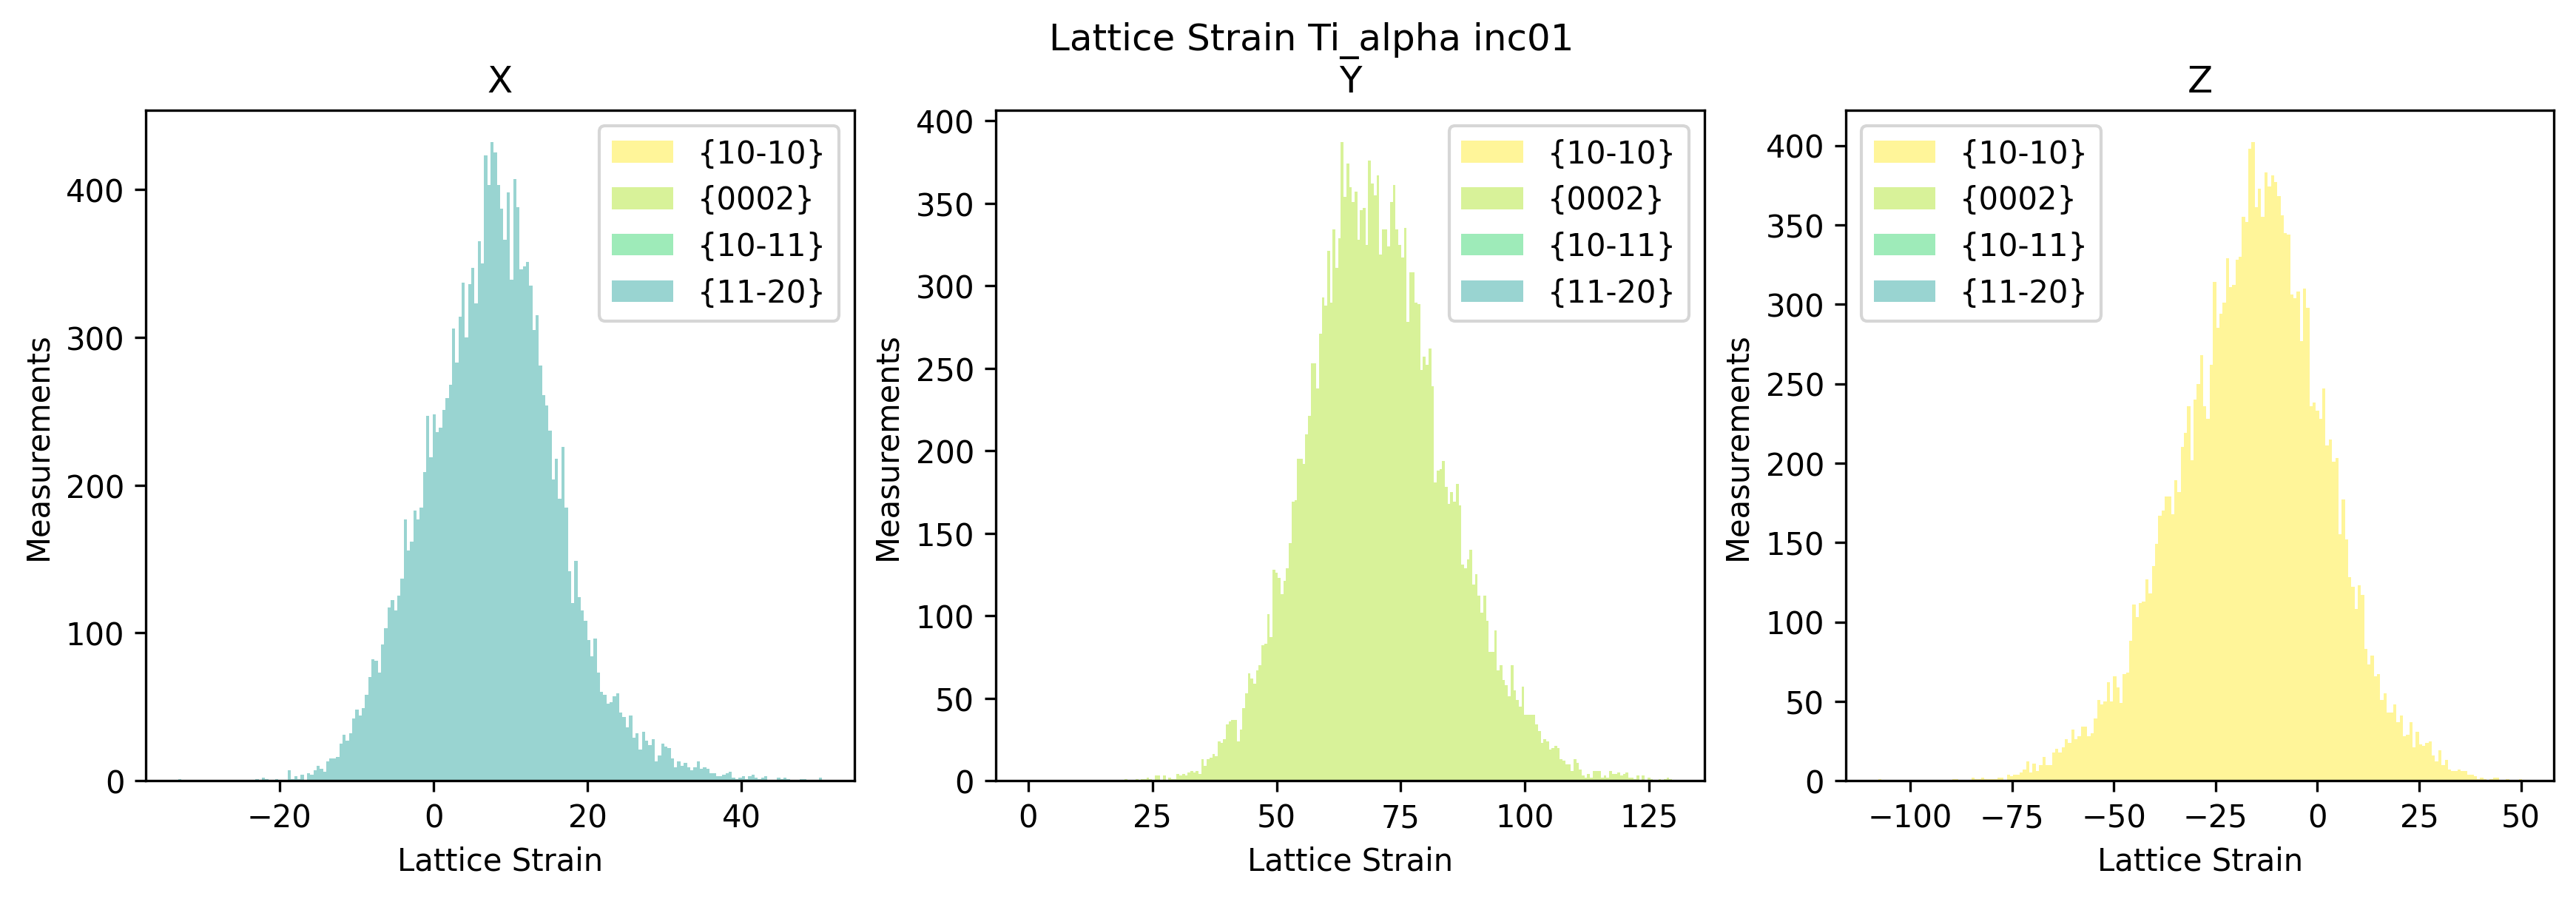

In [12]:
%matplotlib inline

fig, axs = plt.subplots(1,3, figsize=(14, 4), dpi=300) # one row, three coloumns
for i, axis in enumerate(axes):
    plot_lattice_strain_dist_inc(axs[i], latticestrain, axis,
                                 phase="Ti_alpha", inc=1, bins=200,
                                 xmin=None, xlim=None,
                                 ylim=None)
fig.suptitle(f"Lattice Strain Ti_alpha inc01")

plt.savefig(workflow_dir+"Latticestrain_dist", dpi='figure')


## Functions required for lattice strains

In [2]:
import numpy as np
from matflow import utils
from defdap.quat import Quat
from defdap.crystal import CrystalStructure, Phase

def lattice_strain(workflow, phases, axis, tol=5):
    tensor_comp, unit_vector = utils.tensorcomps_fromaxis(axis)

    latticestrain = {}
    plane_intensity = {}
    for phase_name, phase in phases.items():
        print(f"Processing phase {phase_name}...")

        # define volume_element_response data from simulation...
        ve_response = workflow.tasks.simulate_volume_element_loading.elements[0].outputs.volume_element_response

        # get indicies for desired phase...
        phase_idx = ve_response['field_data']['phase']['meta']['phase_names'].index(phase_name)
        phase_mask = ve_response['field_data']['phase']['data'] == phase_idx

        # Using left Cauchy-Green defomation tensor for elastic strain...
        Ee = ve_response['field_data']['epsilon_V^2(F_e)']['data'][:, phase_mask, :, :]
        Ee_incs = ve_response['field_data']['epsilon_V^2(F_e)']['meta']['increments']

        # get number of increments...
        ori_in = ve_response['field_data']['O']['data']
        ori_incs = ve_response['field_data']['O']['meta']['increments']

        # ensure increments are correct
        assert Ee_incs == ori_incs
        incs = ori_incs
        assert ori_in['type'] == 'quat'
        assert ori_in['quat_component_ordering'] == 'scalar-vector'
        assert ori_in['unit_cell_alignment']['x'] == 'a'

        # get orientation data for phase...
        quat_comps = ori_in['quaternions'][:, phase_mask, :]
        # convert to P = +1 convention
        if ori_in['P'] == -1:
            quat_comps[:, :, 1:] *= -1
        ori = np.empty(quat_comps.shape[:-1], dtype=object)
        for i, row in enumerate(quat_comps):
            for j, val in enumerate(row):
                ori[i, j] = Quat(*val)

        latticestrain_phase = {}
        plane_intensity_phase = {}
        for plane_label, crystal_plane in phase.diffraction_planes.items():
            print(f"Processing plane {plane_label} in direction {unit_vector},[{tensor_comp-1},{tensor_comp-1}]...")
            latticestrain_plane = []
            plane_intensity_plane = []
            for inc in incs:
                try:
                    inc_idx = incs.index(inc)
                except ValueError:
                    print(f"Increment {inc} does not exist.")
                    continue
                # determine lit up material points
                lit_up = find_illuminated_points(ori[inc_idx], crystal_plane, phase, incs, unit_vector, tol=5)
                # filter data by illuminated points
                unit_vector /= np.sqrt(np.dot(unit_vector, unit_vector))
                # assert np.allclose(measure_dir, measure_dir), f'expect measure dir to be [1, 0, 0]'
                latticestrain_inc = Ee[inc_idx, lit_up, tensor_comp-1, tensor_comp-1]
            
                # append lattice strain for plane
                latticestrain_plane.append(latticestrain_inc)
                # account for multiplicity of planes here?
                plane_intensity_plane.append(np.count_nonzero(lit_up)/6)
            # append lattice strain for plane to phase
            latticestrain_phase[plane_label] = latticestrain_plane
            plane_intensity_phase[plane_label] = plane_intensity_plane
        # append lattice strain for phase to overall
        latticestrain[phase_name] = latticestrain_phase
        plane_intensity[phase_name] = plane_intensity_phase

    return latticestrain, plane_intensity

In [3]:
def find_illuminated_points(oris, crystal_plane, phase, incs, measure_dir, tol=5, batch_size=100000):
    """
    Find the crystal orientations that will contribute to the diffraction peak of
    a given crystal plane for a given load direction.
    
    Parameters
    ----------
    oris : numpy.ndarray(defdap.quat.Quat)
        Orientation of each point
    crystal_plane : numpy.ndarray
        Crystal plane expressed in Miller-Bravais indicies
    phase : defdap.crystal.Phase
        Defdap phase
    measure_dir : numpy.ndarray
        Direction strain is measured in. Currently only working for z direction (0,0,1)
    tolerance : float
        Tolerance for meeting the Bragg condition, in degrees
    batch_size : int, optional
        Number of orientations to process at one time
        
    """
    sym_group = phase.crystalStructure.name
    
    if sym_group == 'hexagonal':
        crystal_plane_ortho = transform_plane(crystal_plane, phase.cOverA) # only for HCP
    else:
        crystal_plane_ortho = crystal_plane.astype(float)
        crystal_plane_ortho /= np.sqrt(np.dot(crystal_plane_ortho, crystal_plane_ortho))
        
    measure_dir /= np.sqrt(np.dot(measure_dir, measure_dir))
    
    tol = np.cos(tol * np.pi / 180.)

    num_points = oris.shape[0]
    num_batchs = num_points // batch_size + 1

    lit_up = np.zeros(num_points, dtype=bool)

    for i in range(num_batchs):
        oris_batch = oris[i*batch_size:(i+1)*batch_size]
        
        # transform load_dir to crystal coords for all orientations and symmetries

        quat_comps_sym = Quat.calcSymEqvs(oris_batch, sym_group)
        
        # temp variables to use below
        quat_dot_vec = (quat_comps_sym[:, 1, :] * measure_dir[0] +
                        quat_comps_sym[:, 2, :] * measure_dir[1] +
                        quat_comps_sym[:, 3, :] * measure_dir[2])
        temp = (np.square(quat_comps_sym[:, 0, :]) - np.square(quat_comps_sym[:, 1, :]) -
                np.square(quat_comps_sym[:, 2, :]) - np.square(quat_comps_sym[:, 3, :]))
        
        # array to store crytal directions for all orientations and symmetries
        measure_dir_crystal = np.empty((3, quat_comps_sym.shape[0], quat_comps_sym.shape[2]))

        # (quat_comps_sym * measure_dir) * quat_comps_sym.conjugate
        measure_dir_crystal[0] = (2 * quat_dot_vec * quat_comps_sym[:, 1, :] +
                                  temp * measure_dir[0] +
                                  2 * quat_comps_sym[:, 0, :] * (quat_comps_sym[:, 2, :] * measure_dir[2] -
                                                                 quat_comps_sym[:, 3, :] * measure_dir[1]))
        measure_dir_crystal[1] = (2 * quat_dot_vec * quat_comps_sym[:, 2, :] +
                                  temp * measure_dir[1] +
                                  2 * quat_comps_sym[:, 0, :] * (quat_comps_sym[:, 3, :] * measure_dir[0] -
                                                                 quat_comps_sym[:, 1, :] * measure_dir[2]))
        measure_dir_crystal[2] = (2 * quat_dot_vec * quat_comps_sym[:, 3, :] +
                                  temp * measure_dir[2] +
                                  2 * quat_comps_sym[:, 0, :] * (quat_comps_sym[:, 1, :] * measure_dir[1] -
                                                                 quat_comps_sym[:, 2, :] * measure_dir[0]))

        # normalise vectors (just in case)
        measure_dir_crystal /= np.sqrt(np.einsum('ijk,ijk->jk', measure_dir_crystal, measure_dir_crystal))

        dot_prod = np.einsum('ijk,i->jk', measure_dir_crystal, crystal_plane_ortho)
        lit_up[i*batch_size:(i+1)*batch_size] = np.any(np.abs(dot_prod) > tol, axis=0)

#     print("\rDone. {:} points of {:} will contribute to diffraction peak.".format(np.count_nonzero(lit_up), num_points))
    
    return lit_up

In [4]:
def transform_plane(crystal_plane, c_over_a):
    """Transform crystal plane expressed in Miller-Bravais indicies to a unit vector in orthonormal basis."""
    # Convert plane and dir from Miller-Bravais to Miller indicies
    crystal_plane_m = crystal_plane[[0, 1, 3]] # (M-B hkil -> M hkl)

    # Create L matrix. Transformation from crystal to orthonormal coords
    l_matrix = CrystalStructure.lMatrix(1, 1, c_over_a, np.pi / 2, np.pi / 2, np.pi * 2 / 3)

    # Create Q matrix for transforming planes to orthonormal coords
    q_matrix = CrystalStructure.qMatrix(l_matrix)

    # Transform into orthonormal basis and then normalise
    crystal_plane_ortho = np.matmul(q_matrix, crystal_plane_m)
    crystal_plane_ortho /= np.sqrt(np.dot(crystal_plane_ortho, crystal_plane_ortho))

    return crystal_plane_ortho

In [5]:
def process_strain(Ee, lit_up, measure_dir, comp):
    """
    Filter the strain data by the illuminated points.
    
    Parameters
    ----------
    Ee : numpy.ndarray
        Elastic strain tensor at each point, shape (num_points, 3, 3)
    lit_up : numpy.ndarray(bool)
        Boolean array indicating if each point is illuminated, shape (num_points,)
    measure_dir : numpy.ndarray
        Direction strain is to be measured in. Currently only working for z direction (0,0,1)
        
    """    
    measure_dir /= np.sqrt(np.dot(measure_dir, measure_dir))
#     assert np.allclose(measure_dir, measure_dir), f'expect measure dir to be [1, 0, 0]'
    
    measured_strain = Ee[lit_up, comp, comp]
    
    return measured_strain

In [6]:
import matplotlib.pyplot as plt
from cycler import cycler

def plot_latticestrain(axs, true_stress, latticestrain, axis, incs="*", xlim=None, ylim=None):
    
    phase_names = [
             'Ti_alpha',
             'Ti_beta',
             ]

    custom_cycler = (cycler(color=[
                                   '#FFE800', '#9FDF00', '#0DCD52', '#00948D', # alpha colours
                                   '#67001F', '#DF2179', '#CDA0CD' # beta colours
                                  ]) +
                     cycler(marker=[
                                    's', 'h', '^', 'D', # alpha markers
                                    '+', 'x', 'P' # beta markers
                                   ]))
    axs.set_prop_cycle(custom_cycler)
    
    latticestrain_mean = {}
    for phase_name, latticestrain_phase in latticestrain[axis].items():
        latticestrain_phase_mean = {}
        for plane_label, strains in latticestrain_phase.items():
            latticestrain_phase_mean[plane_label] = np.array([strain.mean() for strain in strains])
        latticestrain_mean[phase_name] = latticestrain_phase_mean

    for phase in phase_names:
        for plane_label, mean_strain in latticestrain_mean[phase].items():
            total_microstrain = np.array([0] + mean_strain) * 1e6 # convert to microstrain (1e6)
            axs.plot(total_microstrain, true_stress, label=plane_label)

    axs.title.set_text(f"{axis}")
    axs.set_xlabel("Lattice Strain ($10^{-6}$)")
    axs.set_xlim([None, xlim])
    axs.set_ylabel("True Stress $\sigma$ (MPa)")
    axs.set_ylim([None, ylim])
    axs.legend()
    

In [7]:
def plot_true_strain_vs_peakint(axs, plane_intensity, true_strain, axis, xlim=None, ylim=None):

    phase_names = [
             'Ti_alpha',
             'Ti_beta',
             ]
    
    # maybe the colours are just wrong??
    custom_cycler = (cycler(color=[
                                   '#FFE800', '#9FDF00', '#0DCD52', '#00948D', # alpha
                                   '#67001F', '#DF2179', '#CDA0CD' # beta
                                  ]) +
                     cycler(marker=[
                                    's', 'h', '^', 'D', # alpha
                                    '+', 'x', 'P' # beta
                                   ]))
    
    custom_cycler = (cycler(color=[
                                   '#FFE800', '#9FDF00', '#0DCD52', '#00948D', # alpha
                                   '#67001F', '#DF2179', '#CDA0CD' # beta
                                  ]) +
                     cycler(marker=[
                                    's', 'h', '^', 'D', # alpha
                                    '+', 'x', 'P' # beta
                                   ]))
    
    axs.set_prop_cycle(custom_cycler)

    for phase in phase_names:
        for plane_label, peakint in plane_intensity[axis][phase].items():
            
            # Elements of X-Ray Diffraction 2nd ed., B.D. Cullity, 1978 ISBN 0-201-01174-3
            # alpha
            if plane_label == "{0002}":
                peakint = [intensity / 2 for intensity in peakint]
            elif plane_label == "{10-10}":
                peakint = [intensity / 6 for intensity in peakint]
            elif plane_label == "{10-11}":
                peakint = [intensity / 12 for intensity in peakint]
            elif plane_label == "{11-20}":
                peakint = [intensity / 6 for intensity in peakint]
            # beta
            elif plane_label == "{200}":
                peakint = [intensity / 6 for intensity in peakint]
            elif plane_label == "{110}":
                peakint = [intensity / 12 for intensity in peakint]
                
#             ax.plot(true_strain, peakint, label=plane_label)
            axs.plot(true_strain, peakint, label=plane_label)
            
    axs.title.set_text(f"{axis}")
    axs.set_xlabel(f"True Strain $\epsilon_{{{tensor_comp}{tensor_comp}}}^{{VM}}$")
    axs.set_xlim([None, xlim])
    axs.set_ylabel("Material Point Count")
    axs.set_ylim([None, ylim])
    axs.legend()
    

In [8]:

def plot_lattice_strain_dist_inc(axs, latticestrain, axis, phase, inc, bins=20, xmin=None, xlim=None, ymin=None, ylim=None):
    
    if phase=="Ti_beta":
        colour=np.array(['#67001F', '#DF2179'], dtype='object')
        
    elif phase=="Ti_alpha":
        colour=np.array(['#FFE800', '#9FDF00', '#0DCD52', '#00948D'], dtype='object')

    print(f"phase: {phase} Direction: {axis}")
    for plane_num, plane in enumerate(latticestrain[axis][phase].keys()):
        print(f"\tplane: {plane}\tlattice strain ")
        
#          # Elements of X-Ray Diffraction 2nd ed., B.D. Cullity, 1978 ISBN 0-201-01174-3
#         # alpha
#         if plane == "{0002}":
#             peakint = [intensity / 2 for intensity in peakint]
#         elif plane == "{10-10}":
#             peakint = [intensity / 6 for intensity in peakint]
#         elif plane == "{10-11}":
#             peakint = [intensity / 12 for intensity in peakint]
#         elif plane == "{11-20}":
#             peakint = [intensity / 12 for intensity in peakint]
#         # beta
#         elif plane == "{200}":
#             peakint = [intensity / 6 for intensity in peakint]
#         elif plane == "{110}":
#             peakint = [intensity / 12 for intensity in peakint]
        
        # calculate how many numbers within stdev around mean
        lattstrain_dist = latticestrain[axis][phase][plane][inc]
        axs.hist(lattstrain_dist*1e6, bins=bins,
                alpha=0.4, color=colour[plane_num],
                label=plane)

    axs.legend()
    axs.title.set_text(f"{axis}")
    axs.set_xlabel("Lattice Strain")
    axs.set_xlim(xmin, xlim)
    axs.set_ylabel("Measurements")
    axs.set_ylim(ymin, ylim)


## Add a static.vtk datasets to incremental .vtk s

In [25]:

from damask import VTK
import os

os.mkdir(workflow_dir+"viz+phase/")

for inc in range(0, 101):
    vtk_data = VTK.load(f'{workflow_dir}viz+phase/geom_load_inc{str(inc).zfill(3)}.vtr')
    vtk_phase = VTK.load(f'{workflow_dir}viz+phase/static_outputs.vtr')
    vtk_data.add(vtk_phase.get('phase'), label='phase') # Add phase data to defined vtk_data
    vtk_data.save(f'{workflow_dir}viz+phase/phase_geom_load_inc{str(inc).zfill(3)}.vtr') # overwrite originals


## Add IPF of the inital microstructure to the DAMASK grid file using material.yaml
(Can't get this to work yet)

In [21]:
import damask
import numpy as np

geom = '/mnt/iusers01/jf01/y15576gb/\
postprocessing/check_VE_IPF_2022-12-15-110342/geom.vtr'        # path for geometry file
material_config = '/mnt/iusers01/jf01/y15576gb/\
postprocessing/check_VE_IPF_2022-12-15-110342/material.yaml'    # path for material.yaml

v = damask.VTK.load(geom)
material_ID = v.get('material').flatten()


In [19]:

ma = damask.ConfigMaterial.load(material_config)

phases = list(ma['phase'].keys())
info = []

for m in ma['material']:
    c = m['constituents'][0]
    phase = c['phase']
    info.append({'phase':   phase,
                 'phaseID': phases.index(phase),
                 'lattice': ma['phase'][phase]['lattice'],
                 'O':       c['O'],
                })

l = np.array([0,1,0])                            # lab frame direction for IPF

IPF = np.ones((len(material_ID),3),np.uint8)
for i,data in enumerate(info):
    IPF[np.where(material_ID==i)] = \
    np.uint8(damask.Orientation(data['O'],lattice=data['lattice']).IPF_color(l)*255)

v = v.add(IPF, f'IPF_{l}') # for some reason changes v from VTK to nonetype???

p   = np.array([d['phase'] for d in info])
pid = np.array([d['phaseID'] for d in info])
v = v.add(p[material_ID],'phase')
v = v.add(pid[material_ID],'phaseID')

v.save('VE_initial_IPF')


AttributeError: 'NoneType' object has no attribute 'add'